# Project 1

----

### This notebook uses Price data and Power Plant data (Location, Production) by State

## Dependencies and Setup

In [1]:
# Import dependencies
import os
import pandas as pd

import requests
import json
from pprint import pprint

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
from scipy.stats import linregress



# Import API key
from Gabriel_Key import g_key, EIA_Key
# Change the API key (Gabriel Notebook only)
api_key = EIA_Key

#### List of States

In [2]:
# List of States used in this study
states = ["AL","AK","AZ", "AR","CA","CO","CT", "DE","FL","GA", "HI", "ID", "IL","IN", "IA","KS", 
          "KY","LA","ME","MD","MA","MI","MN", "MS","MO","MT", "NE","NV","NH","NJ","NM","NY","NC",
          "ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

## Electricity Price by State by Year

In [3]:
#setting up API url to get the price

url = "http://api.eia.gov/series/?api_key="



elect_qua_price_df = pd.DataFrame(columns = ["State","2020 price","2019 price","2018 price",
                                             "2017 price","2016 price","2015 price","2014 price",
                                             "2013 price","2012 price","2011 price","2010 price"])

#looping through the call to get information calling API calling for price
for state in states:
    elec_df_q = requests.get(url+ api_key +"&series_id=ELEC.PRICE."+state+"-ALL.Q").json()
    Q1 = elec_df_q['series'][0]['data'][1][1]
    Q2 = elec_df_q['series'][0]['data'][0][1]
    elec_df_y = requests.get(url+ api_key +"&series_id=ELEC.PRICE."+state+"-ALL.A").json()
    yr_2020 = round((Q1+Q2)/2,2)
    new_row_df = {"State": state,"2020 price":yr_2020 ,
               "2019 price":elec_df_y['series'][0]['data'][0][1],
               "2018 price":elec_df_y['series'][0]['data'][1][1],
               "2017 price":elec_df_y['series'][0]['data'][2][1],
               "2016 price":elec_df_y['series'][0]['data'][3][1],
               "2015 price":elec_df_y['series'][0]['data'][4][1],
               "2014 price":elec_df_y['series'][0]['data'][5][1],
               "2013 price":elec_df_y['series'][0]['data'][6][1],
               "2012 price":elec_df_y['series'][0]['data'][7][1],
               "2011 price":elec_df_y['series'][0]['data'][8][1],
               "2010 price":elec_df_y['series'][0]['data'][9][1]
                 }
    elect_qua_price_df = elect_qua_price_df.append(new_row_df, ignore_index=True)

In [4]:
elect_qua_price_df.head()

,State,2020 price,2019 price,2018 price,2017 price,2016 price,2015 price,2014 price,2013 price,2012 price,2011 price,2010 price
0,AL,9.73,9.88,9.63,9.83,9.56,9.33,9.27,9.02,9.18,9.10,8.89
1,AK,20.15,20.43,19.36,19.10,17.93,17.59,17.46,16.49,16.33,16.08,14.76
2,AZ,10.30,10.64,10.85,10.64,10.33,10.34,10.18,10.14,9.81,9.71,9.69
3,AR,8.09,8.13,7.78,8.26,8.13,8.19,7.90,7.93,7.62,7.43,7.28
4,CA,17.03,17.04,16.58,16.06,15.23,15.42,15.15,14.30,13.53,13.05,13.01


## Power Plant by State (Based on EIA, 2020)

In [5]:
# Category by State Plant
url = "http://api.eia.gov/category/?"

category_id = "1017"

# Build query URL
query_url = url + "api_key=" + EIA_Key + "&category_id=" + category_id

# Request data using the API
eia_response = requests.get(query_url).json()

In [6]:
# Retrieve the category key for each state
category_id = []
name_state = []
for i in range(len(eia_response['category']['childcategories'])):
    category_id.append(eia_response['category']['childcategories'][i]['category_id'])
    name_state.append(eia_response['category']['childcategories'][i]['name'])

In [7]:
# Create dataframe to store the data from plant numbers
power_plants_state_df = pd.DataFrame({'State':name_state, 'category_id': category_id,'Power Plants (EIA, 2020)':''})

In [8]:
# Category: Number of power plants by state
url = "http://api.eia.gov/category/?"


for row, index in power_plants_state_df.iterrows():
    
    category_id = str(power_plants_state_df['category_id'].iloc[row])

    # Build query URL
    query_url = url + "api_key=" + EIA_Key + "&category_id=" + category_id

    
    # Request data using the API
    eia_response = requests.get(query_url).json()

    # Load the dataframe column with state category id
    power_plants_state_df['Power Plants (EIA, 2020)'].iloc[row] = len(eia_response['category']['childcategories'])

/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
# Remove District of Columbia
power_plants_state_df.drop(power_plants_state_df.loc[power_plants_state_df['State'] == 'District of Columbia'].index, inplace=True)

In [10]:
# Replace the Full State Name by Abbreviations
power_plants_state_df['State'] = states

In [11]:
# Reset index
power_plants_state_df.reset_index(drop=True, inplace=True)

## Location of Power Plants by State (eGRID2018 Data)

In [12]:
# Import eGRID2018_Data_v2 from (https://www.epa.gov/energy/egrid)

# Create a xls object
xls = pd.ExcelFile('../data/egrid2018_data_v2.xlsx')

# Import the data
eGRID2018_PLNT18_df = pd.read_excel(xls, 'PLNT18')

# Drop extra title row
eGRID2018_PLNT18_df.drop([0], inplace=True)

In [13]:
# List all the Power Plants with all the info available in the csv file
plant_df = eGRID2018_PLNT18_df[['DOE/EIA ORIS plant or facility code','Plant state abbreviation', 'Plant annual net generation (MWh)','Plant name','Plant latitude', 'Plant longitude']]
plant_df.rename(columns = {'DOE/EIA ORIS plant or facility code': 'Code', 
                           'Plant state abbreviation': 'State', 
                           'Plant name': 'Plant Name', 
                           'Plant latitude': 'Latitude', 
                           'Plant longitude': 'Longitude'}, inplace=True)

/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
plant_df.head()

,Code,State,Plant annual net generation (MWh),Plant Name,Latitude,Longitude
1,60814,AK,NaN,7-Mile Ridge Wind Project,63.2107,-143.247
2,54452,AK,NaN,Agrium Kenai Nitrogen Operations,60.6732,-151.378
3,57053,AK,0,Alakanuk,62.6833,-164.654
4,58982,AK,23077,Allison Creek Hydro,61.0844,-146.353
5,60243,AK,1206,Ambler,67.088,-157.857


In [15]:
print(f"The total number of power plants is {plant_df['Code'].count()}.")


The total number of power plants is 10964.


In [17]:
plant_df['text'] = plant_df['Plant Name'] + ', ' + plant_df['State'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = plant_df['Longitude'],
        lat = plant_df['Latitude'],
        text = plant_df['text'],
        mode = 'markers',
        ))

fig.update_layout(
        title = 'US Electricity Power Plants',
        geo_scope='usa',
    )
fig.show()
fig.write_image("Fig_Plants_Locations.png")

/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
# plant_df.drop(plant_df.iloc[plant_df['State']=='DC'])
# Remove District of Columbia
plant_df.drop(plant_df.loc[plant_df['State'] == 'DC'].index, inplace=True)

/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
num_plants_state = pd.Series(plant_df.groupby('State')['Plant annual net generation (MWh)'].count())

In [60]:
power_plants_state_df['Power Plants (eGRID2018Data, 2018)'] = ''
# Update the dataframe with number os power plants from Grid csv file
n = 0
for row in power_plants_state_df.iterrows():
    power_plants_state_df['Power Plants (eGRID2018Data, 2018)'].loc[power_plants_state_df['State'] == num_plants_state.index[n]] = num_plants_state[n]
    n += 1

/Users/gabrielpivaro/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Total Generation by State

In [61]:
# EIA Data Sets > Electricity > Net generation
# Summation of all fuels used for electricity generation; All sectors
url = "http://api.eia.gov/series/?"

electricity_generation_df = pd.DataFrame({'State':states,'Year':'','Total generation (MWh)':''})


for n in range(len(states)):
    # Series
    series_id = "ELEC.GEN.ALL-" + states[n] + "-99.A"
    
    # Build query URL
    query_url = url + "api_key=" + EIA_Key + "&series_id=" + series_id

    # Request data using the API
    eia_response = requests.get(query_url).json()
    
    # Parse the data and store in the data frame
    electricity_generation_df['Year'].iloc[n] = eia_response['series'][0]['data'][1][0]
    electricity_generation_df['Total generation (MWh)'].iloc[n] = eia_response['series'][0]['data'][1][1]*1000


## Agregate Data and Save

In [62]:
# Merge the all three dataframes used in this notebook
power_plant_df = pd.merge(elect_qua_price_df[['State','2018 price']], 
                          power_plants_state_df,on=["State"])

In [63]:
# electricity_generation_df[['State','Total generation (MWh)']].head()
power_plant_df = power_plant_df.merge(electricity_generation_df[['State','Total generation (MWh)']],on=["State"])
power_plant_df.head()

,State,2018 price,category_id,"Power Plants (EIA, 2020)","Power Plants (eGRID2018Data, 2018)",Total generation (MWh)
0,AL,9.63,902931,88,77,1.45058e+08
1,AK,19.36,902932,210,143,6.24736e+06
2,AZ,10.85,902933,152,128,1.11925e+08
3,AR,7.78,902934,70,58,6.79994e+07
4,CA,16.58,902935,1606,1390,1.95466e+08


In [64]:
fig = go.Figure(data=go.Choropleth(
    locations=power_plant_df['State'], # Spatial coordinates
    z = power_plant_df['2018 price'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Price (Cents per KWh)",
))

fig.update_layout(
    title_text = 'US Electricity Cost by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image("Fig_Electricity_Cost_State.png")

In [65]:
fig = go.Figure(data=go.Choropleth(
    locations=power_plant_df['State'], # Spatial coordinates
    z = power_plant_df['Power Plants (eGRID2018Data, 2018)'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Power Plants",
))

fig.update_layout(
    title_text = 'Power Plants by State Power Plants',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image("Fig_Plants_State.png")

In [66]:
x_values = np.array(power_plant_df['Power Plants (eGRID2018Data, 2018)'].astype(float))
y_values = np.array(power_plant_df['2018 price'].astype(float))

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))

The r-squared is: 0.025061970496690296
The correlation coefficient (r) is 0.16
The p-value is 0.2721836785411621


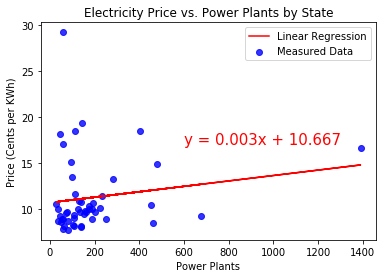

In [67]:
# plt.figure(figsize=(15,6))

plt.scatter(x=x_values, y=y_values, marker="o", facecolors="blue", alpha=0.8)

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (600, 17), fontsize=15, color="red")

plt.xlabel('Power Plants')
plt.ylabel('Price (Cents per KWh)')
plt.title(f"Electricity Price vs. Power Plants by State");
print(f"The r-squared is: {rvalue**2}")
plt.legend(['Linear Regression', 'Measured Data'])
plt.savefig('Fig_Scatter_Price_Plants.png')


# Pearson's Correlation Coefficient | Run the correlation and p-value
correlation = stats.pearsonr(x_values, y_values)
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

In [68]:
fig = go.Figure(data=go.Choropleth(
    locations=power_plant_df['State'], # Spatial coordinates
    z = power_plant_df['Total generation (MWh)'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "MWh",
))

fig.update_layout(
    title_text = 'US Total Electricity generation by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image("Fig_Generation_State.png")

In [69]:
x_values = np.array(power_plant_df['Total generation (MWh)'].astype(float))
y_values = np.array(power_plant_df['2018 price'].astype(float))

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,9)) + "x + " + str(round(intercept,2))

The r-squared is: 0.06358941157965294
The correlation coefficient (r) is -0.25
The p-value is 0.07728168575850225


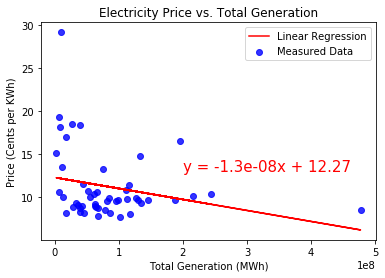

In [70]:
# plt.figure(figsize=(15,6))

plt.scatter(x=x_values, y=y_values, marker="o", facecolors="blue", alpha=0.8)

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (200000000, 13), fontsize=15, color="red")


plt.xlabel('Total Generation (MWh)')
plt.ylabel('Price (Cents per KWh)')
plt.title(f"Electricity Price vs. Total Generation");
print(f"The r-squared is: {rvalue**2}")
plt.legend(['Linear Regression', 'Measured Data'])
plt.savefig('Fig_Scatter_Generation.png')

# Pearson's Correlation Coefficient | Run the correlation and p-value
correlation = stats.pearsonr(x_values, y_values)
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

In [71]:
from scipy import stats
stats.ttest_ind((power_plant_df['2018 price']), (power_plant_df['Power Plants (eGRID2018Data, 2018)']))

Ttest_indResult(statistic=-5.557082220165098, pvalue=2.3627323383930974e-07)

In [72]:
from scipy import stats
stats.ttest_ind((power_plant_df['2018 price']), (power_plant_df['Total generation (MWh)']))

Ttest_indResult(statistic=-7.387748478194399, pvalue=5.009914421222442e-11)

In [73]:
from scipy import stats
stats.ttest_ind((power_plant_df['Power Plants (eGRID2018Data, 2018)']), (power_plant_df['Total generation (MWh)']))

Ttest_indResult(statistic=-7.387733323636824, pvalue=5.0102809562087075e-11)

In [74]:
x_values = np.array(power_plant_df['Power Plants (eGRID2018Data, 2018)'].astype(float))
y_values = np.array(power_plant_df['Total generation (MWh)'].astype(float))

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

The r-squared is: 0.18974356146666668
The correlation coefficient (r) is 0.44
The p-value is 0.0015682866242909628


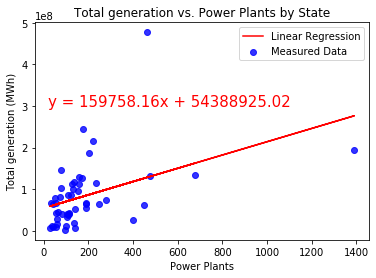

In [75]:
# plt.figure(figsize=(15,6))

plt.scatter(x=x_values, y=y_values, marker="o", facecolors="blue", alpha=0.8)

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (22, 300000000), fontsize=15, color="red")

plt.xlabel('Power Plants')
plt.ylabel('Total generation (MWh)')
plt.title(f"Total generation vs. Power Plants by State");
print(f"The r-squared is: {rvalue**2}")
plt.legend(['Linear Regression', 'Measured Data'])
plt.savefig('Fig_Scatter_Price_Plants.png')

# Pearson's Correlation Coefficient | Run the correlation and p-value
correlation = stats.pearsonr(x_values, y_values)
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

Normality Test: 1.0689553471458046e-09


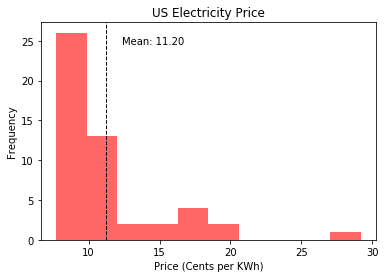

In [76]:
# Plot the histogram for the price
plt.hist(power_plant_df['2018 price'], color='red', alpha=0.6)
plt.title("US Electricity Price")
plt.xlabel('Price (Cents per KWh)')
plt.ylabel('Frequency')
plt.axvline(power_plant_df['2018 price'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(power_plant_df['2018 price'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(power_plant_df['2018 price'].mean()))
plt.savefig('Fig_Hist_Price.png')
print(f"Normality Test: {stats.normaltest(power_plant_df['2018 price'])[1]}")

In [77]:
power_plant_df['2018 price'].describe()

count    50.0000
mean     11.2048
std       4.0581
min       7.7100
25%       8.8650
50%       9.7100
75%      11.2625
max      29.1800
Name: 2018 price, dtype: float64

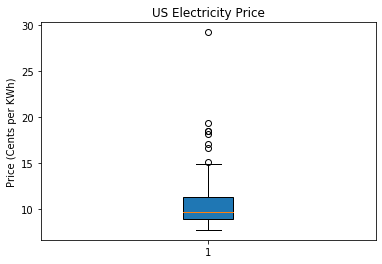

In [78]:
# plt.figure(figsize=(10,5))
plt.title('US Electricity Price')
plt.ylabel('Price (Cents per KWh)')
plt.boxplot(power_plant_df['2018 price'],patch_artist=True)
plt.savefig('Fig_Box_Price.png')
# plt.show()

## Hipothesis Statistical Test

For the number of power plants:
H0: The number of power plants inside one state has no impact in the price of electricity in the price within that state.


H1: The number of power plants inside one state has impact in the price of electricity in the price within that state.
For the number of power plants:
H0: The total generated electricity of the state one state has no impact in the price of electricity in the price within that state.


H1: The total generated electricity of the state one state has impact in the price of electricity in the price within that state.
